In [1]:
import torch
from torch import Tensor
from mytransformers import TransformerEncoderDecoderModel, ModelTrainer
from mytransformers import layers
import torch.nn as nn
device = torch.device('cuda')

In [2]:
VOCAB_SIZE = 5000
MAX_LEN = 128

PAD_TOKEN_ID = 0
UNK_TOKEN_ID = 1
BOS_TOKEN_ID = 2
EOS_TOKEN_ID = 3

In [3]:
from datasets import load_dataset

print("Download TinyStories...")
dataset = load_dataset("roneneldan/TinyStories",
                       split=f"train[:{VOCAB_SIZE}]")

with open("tinystories.txt", "w") as f:
    for example in dataset:
        text = example["text"].strip().lower()
        f.write(text + "\n")

print("Save in tinystories.txt")

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download TinyStories...
Save in tinystories.txt


In [4]:
import sentencepiece as spm

spm.SentencePieceTrainer.train(
    input='tinystories.txt',
    model_prefix='tiny_tokenizer',
    vocab_size=VOCAB_SIZE,
    model_type='bpe',
    character_coverage=1.0,
    pad_id=PAD_TOKEN_ID,
    unk_id=UNK_TOKEN_ID,
    bos_id=BOS_TOKEN_ID,
    eos_id=EOS_TOKEN_ID,
    minloglevel=2 
)

print("Токенизатор обучен: tiny_tokenizer.model")

sp = spm.SentencePieceProcessor()
sp.load("tiny_tokenizer.model")

Токенизатор обучен: tiny_tokenizer.model


True

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class StoryDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=64):
        self.texts = [t.strip().lower() for t in texts]
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad_id = 0
        self.bos_id = 2
        self.eos_id = 3

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        ids = self.tokenizer.encode(text, out_type=int)

        if len(ids) > self.max_len - 2:
            ids = ids[:self.max_len - 2]

        input_ids = [self.bos_id] + ids + [self.eos_id]
        target_ids = [self.bos_id] + ids + [self.eos_id]

        padding = [self.pad_id] * (self.max_len - len(input_ids))
        input_ids += padding
        target_ids += padding

        return {
            "source": torch.tensor(input_ids),
            "target": torch.tensor(target_ids)
        }

texts = [ex["text"] for ex in dataset]
story_dataset = StoryDataset(texts, sp, max_len=MAX_LEN + 1)

In [ ]:
NUM_LAYERS = 6
HIDDEN_STATE = 256

# Attention
NUM_QUERY_HEADS = 16
NUM_KV_HEADS = 4
QK_DIM = 256
V_DIM = 256

# FFN
FFN_DIM = 512

# MoE

NUM_EXPERTS = 8
K=2

In [8]:

positional_encoding = layers.PositionalEncoding(hidden_state=HIDDEN_STATE, max_len=MAX_LEN)

self_attn = layers.SelfAttention(
    hidden_state=HIDDEN_STATE,
    num_query_heads=NUM_QUERY_HEADS,
    num_kv_heads=NUM_KV_HEADS,
    qk_dim=QK_DIM,
    v_dim=V_DIM
)

cross_attn = layers.CrossAttention(
    hidden_state=HIDDEN_STATE,
    num_query_heads=NUM_QUERY_HEADS,
    num_kv_heads=NUM_KV_HEADS,
    qk_dim=QK_DIM,
    v_dim=V_DIM
)

expert = layers.FeedForward(
    hidden_state=HIDDEN_STATE,
    ffn_dim=FFN_DIM
)

gate = layers.FeedForward(
    hidden_state=HIDDEN_STATE,
    ffn_dim=NUM_EXPERTS,
    func=nn.Softmax(dim=-1)
    
)
ffn = layers.MoELayer(
    num_experts=NUM_EXPERTS,
    k=K,
    expert_model=expert,
    gate_model=gate
)

encoder_layer = layers.TransformerEncoderLayer(
    hidden_state=HIDDEN_STATE,
    attn_model=self_attn,
    ffn_model=ffn
)

decoder_layer = layers.TransformerDecoderLayer(
    hidden_state=HIDDEN_STATE,
    self_attn_model=self_attn,
    ffn_model=ffn,
    encoder_output=True,
    cross_attn_model=cross_attn
)
model = TransformerEncoderDecoderModel(
    vocab_size=VOCAB_SIZE,
    pad_token_id=PAD_TOKEN_ID,
    num_layers=NUM_LAYERS,
    hidden_state=HIDDEN_STATE,
    positional_encoding_model=positional_encoding,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer
    
)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

100%|██████████| 6250/6250 [04:07<00:00, 25.29batch/s, Epoch Loss=0.0059]       


График сохранён: loss_plot.png


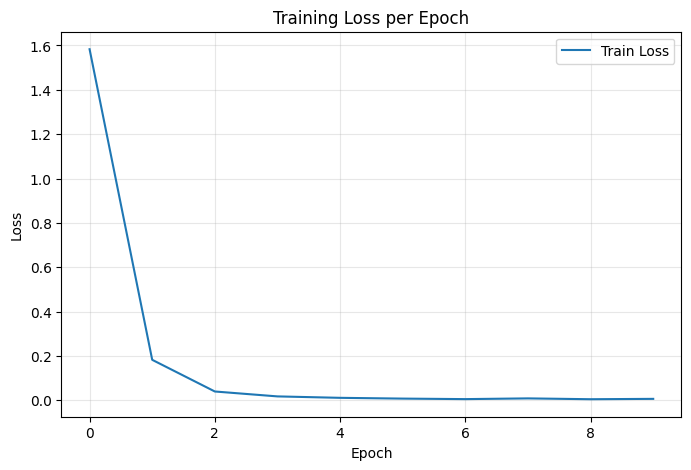

In [11]:
trainer = ModelTrainer(
    num_epochs=10,
    batch_size=8,
    pad_token_id=0 
)

test_losses = trainer.train(
    data=story_dataset,
    model=model,
    optimizer=optimizer,
    criterion=criterion
)

# График
trainer.print_loss_history(path_save="loss_plot")

In [12]:
def generate(model, tokenizer, prompt, max_len=100, device='cuda'):
    model.eval()
    tokens = tokenizer.encode(prompt.lower(), out_type=int)
    tokens = [2] + tokens  # <bos>

    for _ in range(max_len):
        src = torch.tensor([tokens]).to(device)
        tgt = torch.tensor([tokens]).to(device)

        with torch.no_grad():
            logits = model(src, tgt)
            next_token_logits = logits[0, -1, :]  # последний токен
            next_token = torch.argmax(next_token_logits, dim=-1).item()

        if next_token == 3:  # <eos>
            break
        tokens.append(next_token)

    return tokenizer.decode(tokens)

# Пример
prompt = "one day, "
gen = generate(model, sp, prompt, max_len=30)
print("Сгенерировано:", gen)

Сгенерировано: one day, one one one one one one one one one one one one one one one one one one one one one one one one one one one one one one
